In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
def get_historical_data(symbol, start_date = None):
    api_key = 'BPUROSV7R6OUF7NS'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('IBM', '2020-01-01')
ibm

,open,high,low,close,adj close,volume
2020-01-02,135.00,135.920,134.77,135.42,110.146576,3148461.0
2020-01-03,133.57,134.860,133.56,134.34,109.268136,2373470.0
2020-01-06,133.42,134.240,133.20,134.10,109.072927,2421128.0
2020-01-07,133.69,134.960,133.40,134.19,109.146130,3267592.0
2020-01-08,134.51,135.860,133.92,135.31,110.057105,4345952.0
...,...,...,...,...,...,...
2023-03-20,124.31,126.160,124.19,125.94,125.940000,4588304.0
2023-03-21,126.90,127.150,125.66,126.57,126.570000,3856345.0
2023-03-22,127.00,127.215,124.01,124.05,124.050000,3549024.0
2023-03-23,123.81,124.930,122.60,123.37,123.370000,4651936.0


In [3]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
ibm

,open,high,low,close,adj close,volume,rsi_14
2020-01-08,134.51,135.860,133.92,135.31,110.057105,4345952.0,52.899154
2020-01-09,135.74,136.790,135.31,136.74,111.220224,3730549.0,71.911250
2020-01-10,137.00,137.870,136.31,136.69,111.179556,3255398.0,70.834622
2020-01-13,135.48,136.640,135.07,136.60,111.106352,3162843.0,68.836846
2020-01-14,136.28,137.140,135.55,135.82,110.471924,3680958.0,54.492657
...,...,...,...,...,...,...,...
2023-03-20,124.31,126.160,124.19,125.94,125.940000,4588304.0,38.250974
2023-03-21,126.90,127.150,125.66,126.57,126.570000,3856345.0,40.869181
2023-03-22,127.00,127.215,124.01,124.05,124.050000,3549024.0,34.557306
2023-03-23,123.81,124.930,122.60,123.37,123.370000,4651936.0,33.072982


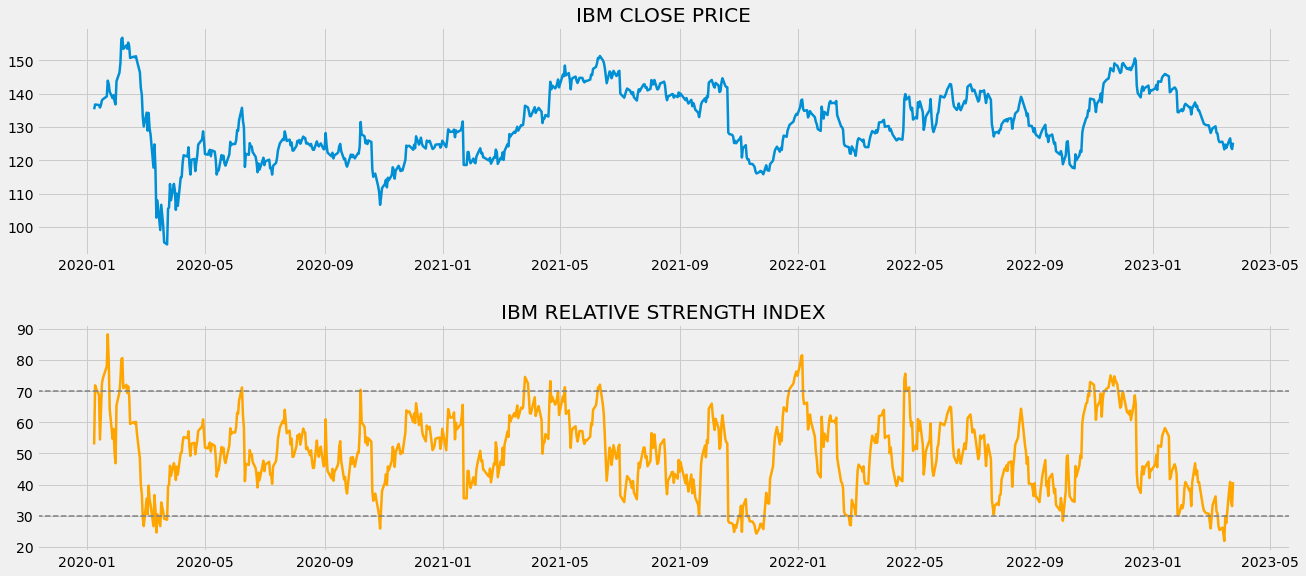

In [4]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('IBM CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('IBM RELATIVE STRENGTH INDEX')
plt.show()

In [5]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

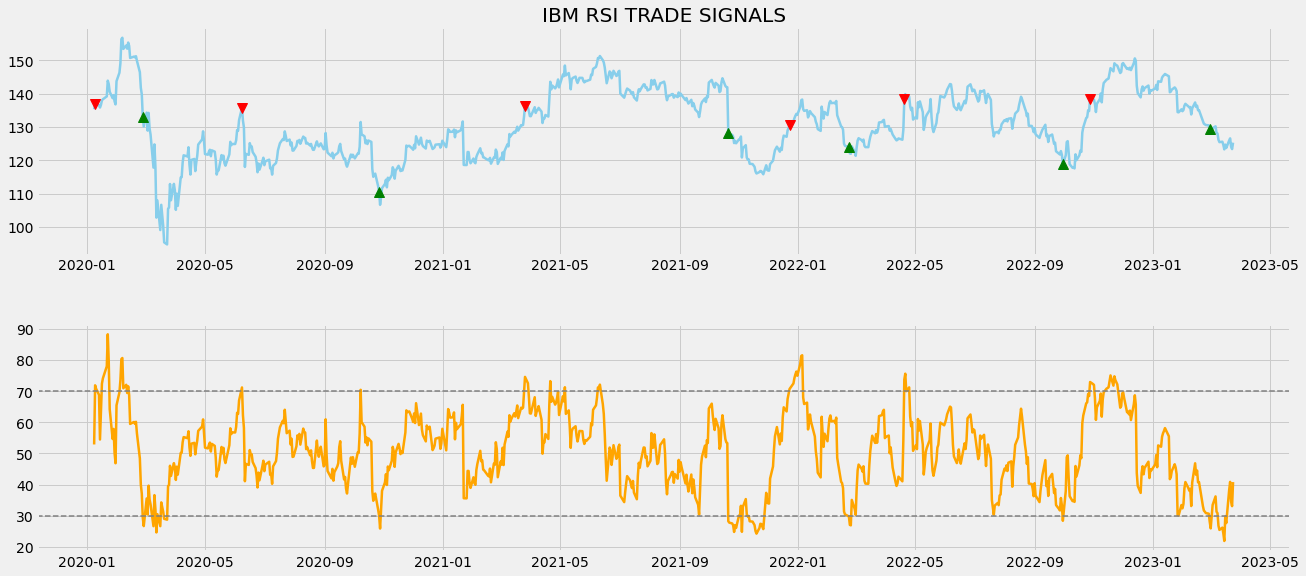

In [6]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('IBM RSI TRADE SIGNALS')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [7]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
2020-01-08,135.31,52.899154,0,1
2020-01-09,136.74,71.911250,-1,0
2020-01-10,136.69,70.834622,0,0
2020-01-13,136.60,68.836846,0,0
2020-01-14,135.82,54.492657,0,0


In [8]:
ibm_ret = pd.DataFrame(np.diff(ibm['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in IBM : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in IBM : 49699.44
Profit percentage of the RSI strategy : 49%
